The blood meal control stock (stock 2) was amplified and sequenced two times. Here we are merging the output snplist files into one file so we can keep the minor variants that were shared between the two and use for downstream analyses (diversity, number of variants, etc).

In [1]:
# load the libraries necessary
library("ggplot2")
library("tidyverse")
library("tidyr")
library('glue')

── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘glue’


The following object is masked from ‘package:dplyr’:

    collapse




In [2]:
# set working directory
wkdir = "/home/kate/Lab/zika_files/ReAlignment/SubVariants/"
setwd(wkdir)

We will input the different BC controls generated by subsampling. 

        1: is 100%
        0.75: 75%
        0.50: 50%
        0.25: 25%
        0.10: 10%
        0.05: 5%

In [3]:
STRAINS = c("ZIKA_1","ZIKA_0.75","ZIKA_0.50","ZIKA_0.25","ZIKA_0.10","ZIKA_0.05")

SEGMENT = 'MR766' # segment name in name of file 

cutoff = 0.01 # minor variant keep cutoff in filename

sample = 'BC_controls/blood_meal_control' # provide directory where the bc controls are located

nts = c('A','G','C','T')

In [4]:
if (!dir.exists(glue("{wkdir}Diversity_figures/Diversity_CompareBC"))) {
      dir.create(glue("{wkdir}Diversity_figures/Diversity_CompareBC"))
    }

In [5]:
PlotCompare = function(df, subtype, savedir){
   x =  ggplot(df, aes(x=minorfreq.x, y=minorfreq.y, color=(minorfreq.x>0.03 & minorfreq.y > 0.03))) +
            geom_vline(xintercept = 0.03, linetype = 2) +
            geom_hline(yintercept = 0.03, linetype = 2) +   
            scale_color_manual(values=c('black','red')) +
            geom_point() +
            ggtitle(subtype) +
            theme_bw()    
    return(x)
}

[1] "ZIKA_1"
[1] "minors are the same"
[1] 65
[1] "minors are different"
[1] 5
[1] 0


Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(names)` instead of `names` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.



[1] "ZIKA_0.75"
[1] "minors are the same"
[1] 65
[1] "minors are different"
[1] 5


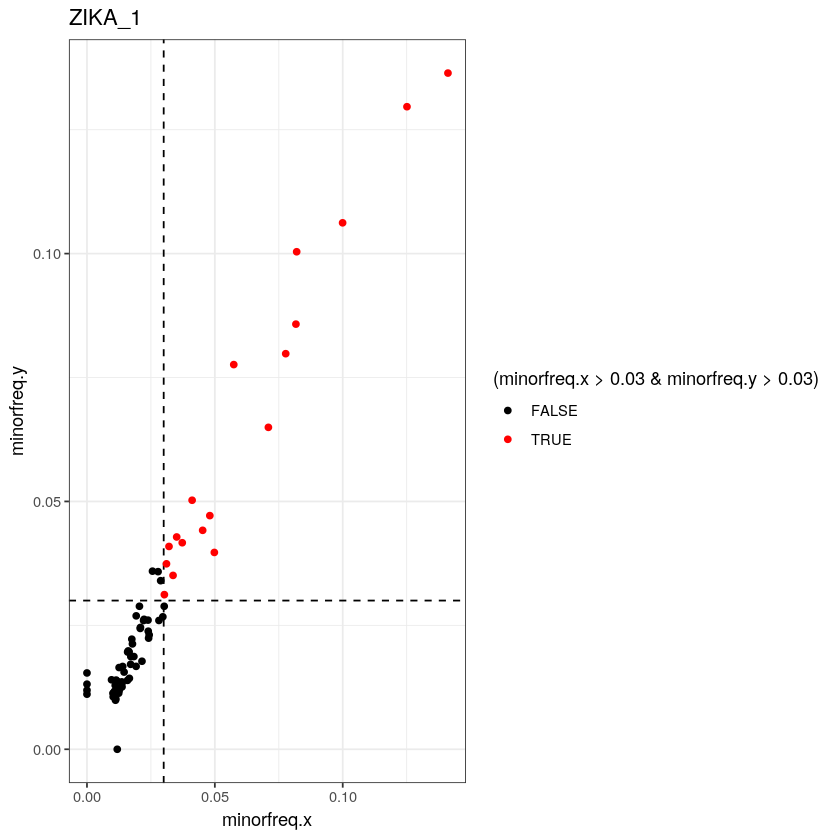

[1] 0
[1] "ZIKA_0.50"
[1] "minors are the same"
[1] 63
[1] "minors are different"
[1] 8


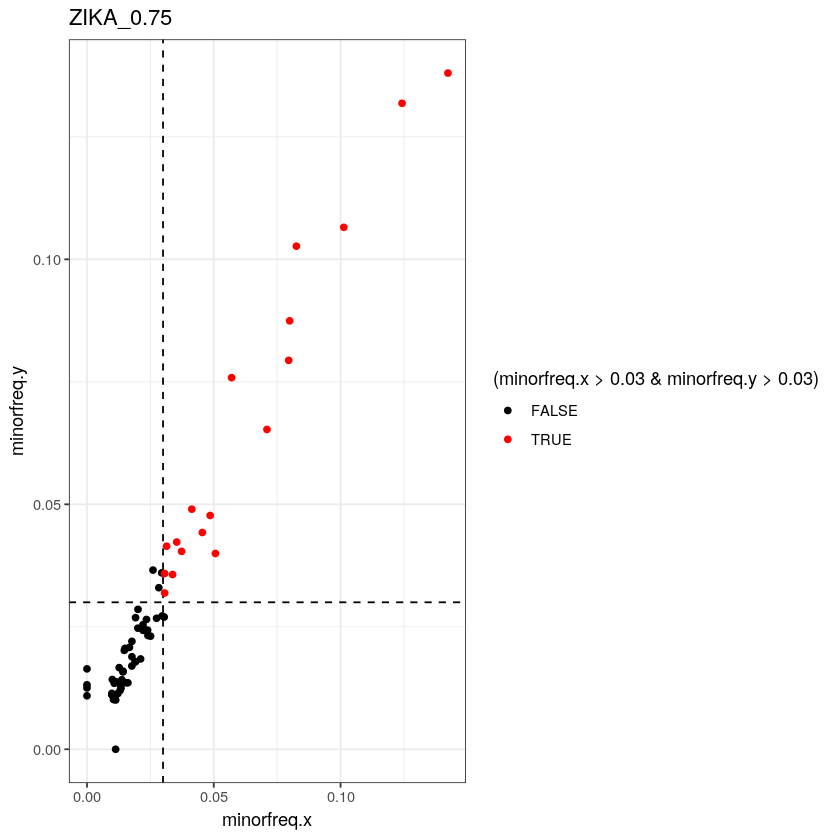

[1] 0
[1] "ZIKA_0.25"
[1] "minors are the same"
[1] 65
[1] "minors are different"
[1] 11


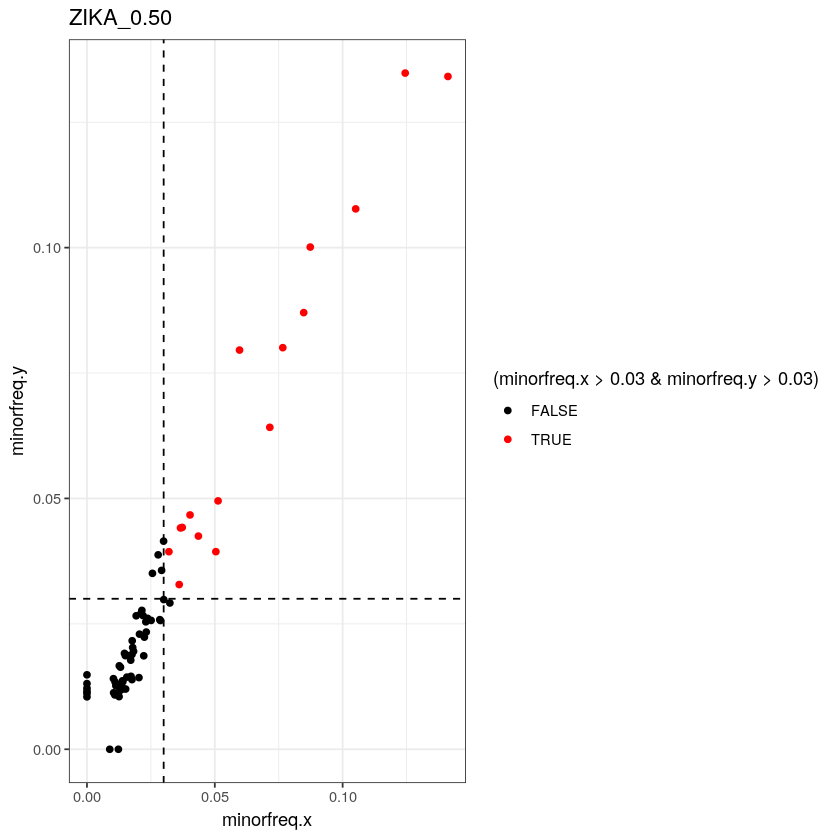

[1] 0
[1] "ZIKA_0.10"
[1] "minors are the same"
[1] 60
[1] "minors are different"
[1] 18


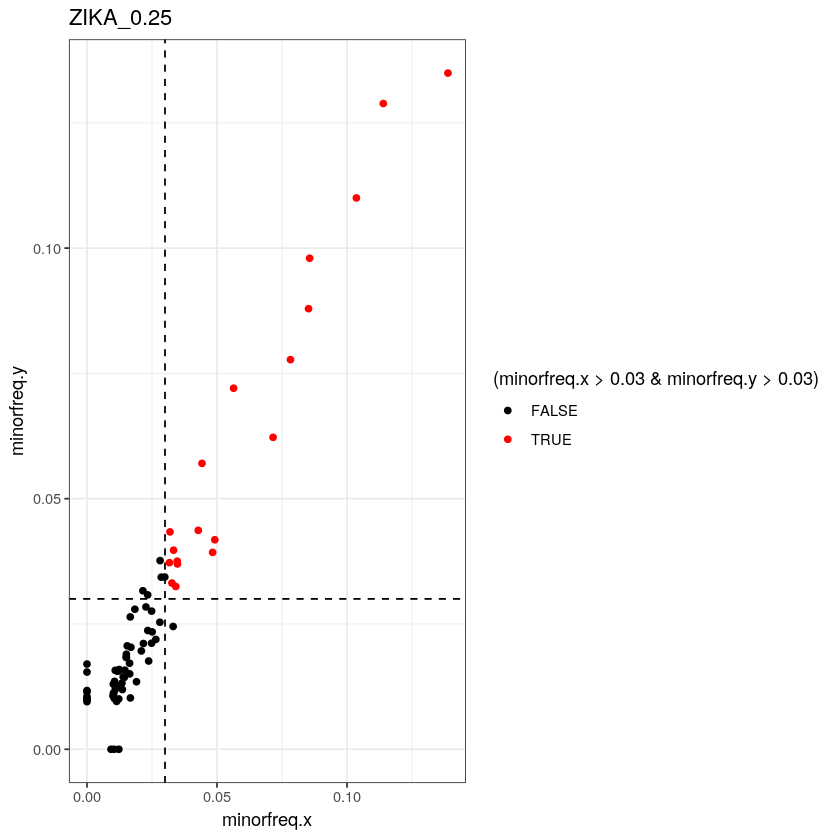

[1] 0
[1] "ZIKA_0.05"
[1] "minors are the same"
[1] 52
[1] "minors are different"
[1] 37


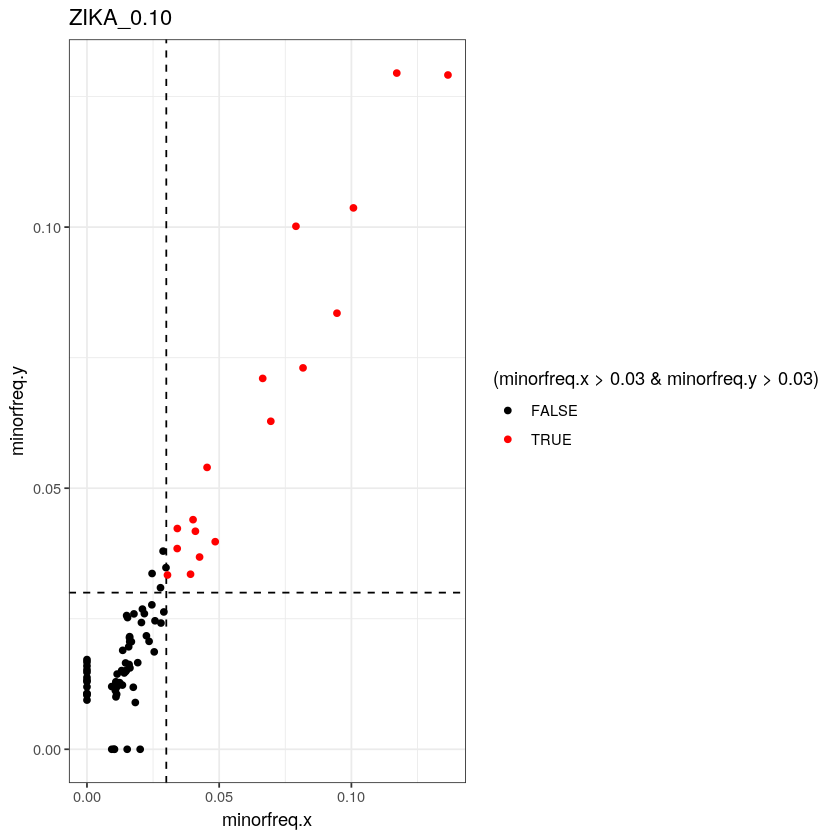

[1] 0


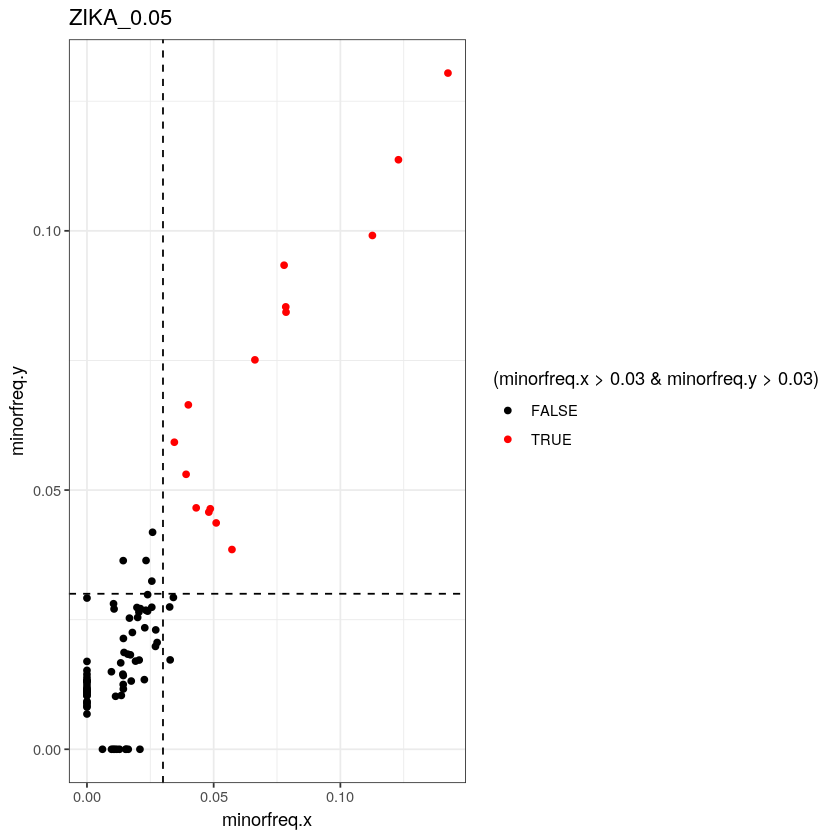

In [6]:
for (STRAIN in STRAINS){
    print(STRAIN)
    # first blood meal control
    BC1 = paste0(sample,'_1.',STRAIN,'.',SEGMENT,'.',cutoff,'.snplist.csv')
    bc1 = read.csv(file=BC1,header=T,sep=",",na.strings = c('nan')) 

    # second blood meal control
    BC2 = paste0(sample,'_2.',STRAIN,'.',SEGMENT,'.',cutoff,'.snplist.csv')
    bc2 = read.csv(file=BC2,header=T,sep=",",na.strings = c('nan')) 
    
    # merge the two samples
    bc_all = merge(bc1,bc2,by=c('segment','ntpos'),all=T)
    names = c(colnames(bc_all))
    
    
    bc.minors = bc_all %>% filter(minor.x %in% nts & minor.x == minor.y) %>% droplevels()
    print("minors are the same")
    print(nrow(bc.minors))
    #print(head(bc.minors))
    
    bc.diff.min = bc_all %>% filter(minor.x != minor.y) %>% filter(minor.x %in% nts | minor.y %in% nts) %>% droplevels()
    print('minors are different')
    print(nrow(bc.diff.min))
    #print(head(bc.diff.min))
    
    bc.wminor = bc_all %>% filter(minor.x %in% nts | minor.y %in% nts)
    bc.wminor$minorfreq.x[is.na(bc.wminor$minorfreq.x)] = 0 
    bc.wminor$minorfreq.y[is.na(bc.wminor$minorfreq.y)] = 0 
    x = PlotCompare(bc.wminor,STRAIN, glue("{wkdir}Diversity_figures/Diversity_CompareBC"))
    print(x)
    
    ggsave(x, 
           file=glue("{wkdir}Diversity_figures/Diversity_CompareBC/CompareBC.{STRAIN}.pdf"),
           width=7, height=4,limitsize=FALSE)
    
    
       
    # check to make sure that the con seqs are identical
    bc.maj = print(nrow(filter(bc_all, major.x != major.y) %>% droplevels())) 

    bc.diff = filter(bc_all, !minor.x != minor.y) %>%
              droplevels() #filter out where minors aren't the same
     
    bc.nomin = filter(bc_all, minor.x != minor.y) %>%
                  select(-c(minor.x,minor.y,minorfreq.x,minorfreq.y,binocheck.x,binocheck.y)) %>%
                  droplevels() #filter for minors that aren't the same and remove minor columns

    bc.min = filter(bc_all, minor.x != minor.y) %>% 
                  select(minor.x, minor.y,minorfreq.x,minorfreq.y,binocheck.x,binocheck.y) %>%
                  droplevels() #filter for minors that aren't the same and minor columns

    bc.min[!is.na(bc.min)] = NA #change all to na as if they don't exist
    bc.bind= cbind(bc.nomin,bc.min) %>%
                  select(names) #bind columns together

    bc = rbind(bc.diff,bc.bind) #add nucleotide positions back to full df
    bc2 =bc #just to keep it safe
    #average everything across the two replicates
    bc2$majorfreq = (bc2$majorfreq.x + bc2$majorfreq.y)/2
    bc2$minorfreq = (bc2$minorfreq.x + bc2$minorfreq.y)/2
    bc2$A = (bc2$A.x + bc2$A.y)/2
    bc2$C = (bc2$C.x + bc2$C.y)/2
    bc2$G = (bc2$G.x + bc2$G.y)/2
    bc2$T = (bc2$T.x + bc2$T.y)/2
    bc2$X = (bc2$X..x + bc2$X..y)/2
    bc2$totalcount = (bc2$totalcount.x + bc2$totalcount.y)/2

    #rename it 
    bc2$name = 'blood_meal_control'

    #rearrange the columns
    bcfin = select(bc2,name,segment,ntpos,major.x,
                   majorfreq,minor.x,minorfreq,binocheck.x,
                   A,C,G,T,X,totalcount,aapos.x,majoraa.x,
                   majorcodon.x, minoraa.x,minorcodon.x) %>%
      droplevels()

    #rename the columns
    colnames(bcfin) = c('name','segment','ntpos','major','majorfreq',
                        'minor','minorfreq','binocheck',
                        'A','C','G','T','-','totalcount',
                        'aapos','majoraa','majorcodon','minoraa',
                        'minorcodon')
    
    write.csv(bcfin,
              file = glue("{wkdir}{sample}.{STRAIN}.{SEGMENT}.{cutoff}.snplist.csv"),
              row.names = F)
    }